# Price prediction using Facebook Prophet

## UXF Class

In [9]:
import pandas as pd
from prophet import Prophet
import plotly.express as px
import yfinance as yf
import plotly.graph_objects as go
import mplfinance as mpf
import datetime as datetime

# UFX class (NOTE: create a class for the dividends notebook and have a method to save all symbols to a csv file)
class UFX:
    
    def __init__(self, symbol):
        # create am initial the symbol list
        self.symbol = symbol
        self.data = self._get_data()
        
    # get the data for the symbol list from yahoo finance and save to a csv file save the date(today) as the first row of the csv file
    def _get_data(self):
        # todo: add a doc string
        # get the data from yahoo finance
        today = datetime.date.today()
        # get data from yahoo finance to use
        symbol_data = yf.download(self.symbol, period='max', end=today)
        return symbol_data
    
    # splice the data when povided a date
    def splice_data(self, df, date, query=False, query_on=''):
        # todo: add a doc string
        if query:
            return df.query(f'{query_on} >= "{date}"')
        return df.loc[date:]    

    def forcasting_preparation(self, df):
        # todo: add a doc string
        df = df.reset_index()
        return df[['Date', 'Close']]
            
    # use prophet to forecast the data
    def forecast_data(self, data):
        # todo: add a doc string
        data = data.rename(columns={'Date': 'ds', 'Close': 'y'})
        model = Prophet()
        model.fit(data)
        future = model.make_future_dataframe(periods=90, freq='D')
        forecast = model.predict(future)
        return forecast
    
    def process_forecasted_data(self, forecast_df):
        df = forecast_df.copy()
        # keep only needed columns in the forecast dataframe
        df = df[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend']]  
        # smooth out the prediction lines
        df['predicted_price'] = df['yhat'].rolling(window=7).mean()
        df['upper_band'] = df['yhat_upper'].rolling(window=7).mean()
        df['lower_band'] = df['yhat_lower'].rolling(window=7).mean()
        return df 

    def merge_dataframes(self, data, forecasted_df):
        merged_df = data.merge(forecasted_df, left_index=True, right_on='ds', how='outer')
        merged_df = merged_df.sort_values(by='ds').set_index('ds')
        return merged_df

    #  using plotly to plot the data. Create a candlstick chart with the 50 moving average
    def plotly_visualize_forecast(self, data, forcast_processed, splice_date='2023-01-01', width=1000, height=800, save_fig=True):
        # todo: add in self to the method
        # splice the data so the chart is readable
        data = self.splice_data(data, splice_date)
        forcast_processed = self.splice_data(forcast_processed, splice_date, query=True, query_on='ds')
        #  get timestamp
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d @ %H:%M:%S")
        date_buttons = [{'count': 9, 'label': '6M', 'step': "month", 'stepmode': "todate"},
                        {'count': 6, 'label': '3M', 'step': "month", 'stepmode': "todate"},
                        {'count': 4, 'label': '1M', 'step': "month", 'stepmode': "todate"}]
        # create the plotly chart
        fig = go.Figure()
        fig.add_trace(go.Candlestick(x=data.index, open=data.Open, high=data.High, low=data.Low, close=data.Close, name='Candlestick', increasing_line_color='#F6FEFF', decreasing_line_color='#1CBDFB'))
        
        # update the layout of the chart with the buttons and timestamp along with some kwargs
        fig.update_layout(  {'xaxis':
                            {'rangeselector': {'buttons': date_buttons, 
                                               'bgcolor': '#444654', 
                                               'activecolor': '#1E82CD',
                                               'bordercolor': '#444654',
                                               'font': {'color': 'white'}}}},
                            width=width, height=height, xaxis_rangeslider_visible=False, 
                            paper_bgcolor='#202123', plot_bgcolor='#202123', font=dict(color='white', size=12)
        ) 
        #  update the layout of the chart with the title and axis labels
        fig.update_layout( 
            {'annotations': [{  "text": f"This graph was last generated on {timestamp}", 
                                "showarrow": False, "x": 0.8, "y": 1.05, "xref": "paper", "yref": "paper"}]},
        )

        fig.update_layout( 
            {'title': {'text':f'{self.symbol} Price Chart', 'x': 0.5, 'y': 0.95}},
            yaxis=dict(title='Price', gridcolor='#444654'), xaxis=dict(gridcolor='#444654')
        )
        
        
        fig.add_trace(go.Scatter(x=forcast_processed.ds, y=forcast_processed.predicted_price, line=dict(color='#B111D6', width=1), name='Predicted Price'))
        fig.add_trace(go.Scatter(x=forcast_processed.ds, y=forcast_processed.trend, line=dict(color='#0074BA', width=1), name='Predicted Trend'))
        fig.add_trace(go.Scatter(x=forcast_processed.ds, y=forcast_processed.upper_band, line=dict(color='#1E82CD', width=2), name='upper_band'))
        fig.add_trace(go.Scatter(x=forcast_processed.ds, y=forcast_processed.lower_band, line=dict(color='#1E82CD', width=2), name='lower_band'))
        fig.show()
        # save the fig plot if the symbol is in the list of symbols
        if save_fig:
            fig.write_html(f"{self.symbol}_plot.html")

    #  MPF function to visualize the forecast (MPL Financer)
    def mpf_visualize_forecast(self, data, splice_date='2023-01-01', style='nightclouds'):
        # todo: add a doc string
        '''Notes:
            -add as a parameter savefig='GLD.png'
            -show available_styles with mpf.available_styles()
            -my favs are 'blueskies', 'charles', 'classic', 'default', 'kenan', 'mike', 'nightclouds'
            -mav(50) is the 50 day simple moving average parameter
            -title=symbol can be used as a parameter to add a title to the plot
        '''
        # splice the data so the chart is readable
        data = self.splice_data(data, splice_date)
        # create additional plots
        additional_plots = [mpf.make_addplot(data['predicted_price'], color='#560BCD', width=1, alpha=0.8),
                            mpf.make_addplot(data['trend'], color='#97caf7', width=1, alpha=0.8),
                            mpf.make_addplot(data['upper_band'], color='#0979FF', width=2, alpha=0.5),
                            mpf.make_addplot(data['lower_band'], color='#0979FF', width=2, alpha=0.5)]
        
        # using mpf to plot the data
        # mpf.plot(data, type='candle', style='nightclouds', title=self.symbol, ylabel='Price', show_nontrading=True , volume=False, figratio=(20,10), figscale=1, tight_layout=True)
        fig, axes = mpf.plot(data, type='candle', style=style, addplot=additional_plots, ylabel='Price', show_nontrading=True , volume=False, figratio=(20,10), figscale=1, tight_layout=True, returnfig=True)

        # Add legend manually
        lines = [line for line in axes[0].get_lines()]
        labels = ['Predicted Price', 'Predicted Trend', 'Upper Band', 'Lower Band']
        axes[0].legend(lines, labels, loc='upper left', title=self.symbol, fancybox=False, shadow=False, framealpha=0.7, fontsize='small')
        
    # show the correlation matrix for the symbol list
    def correlation_matrix(self, data, width=500, height=500):
        # todo: add a doc string
        clean_data = data.dropna(axis=0)
        corr = clean_data.corr()
        # Create a heatmap using Plotly Express
        fig = px.imshow(corr, text_auto=True, color_continuous_scale='PuBuGn', title='Correlation Heatmap', width=width, height=height, template='presentation')
        fig.show()
            



## GLD

In [10]:
def create_instance_gld():
    global GLD
    global GLD_data
    global GLD_forcasting_prep
    global GLD_forecast
    global GLD_processed_forecast
    global GLD_merged_df
    
    # create a "GLD" instance of the UFX class
    GLD = UFX('GLD')
    # splice the data using data starting from 2022-01-01 for forecasting
    GLD_data = GLD.splice_data(GLD.data, '2022-01-01')
    # preppare the data for forecasting
    GLD_forcasting_prep = GLD.forcasting_preparation(GLD_data)
    # forecast the data
    GLD_forecast = GLD.forecast_data(GLD_forcasting_prep)
    # process the forecasted data
    GLD_processed_forecast = GLD.process_forecasted_data(GLD_forecast)
    # merge the dataframes
    GLD_merged_df = GLD.merge_dataframes(GLD_data, GLD_processed_forecast)

# can comment out when playing with the visualizations
create_instance_gld()

# visualizee with plotly
GLD.plotly_visualize_forecast(GLD_data, GLD_processed_forecast, splice_date='2022-01-01', width=1000, height=600, save_fig=False)
# visualize with mplfinance
# todo Note:: fav styles for MPF are 'blueskies', 'charles', 'classic', 'default', 'kenan', 'mike', 'nightclouds'
# GLD.mpf_visualize_forecast(GLD_merged_df, splice_date='2022-01-01', style='nightclouds')

[*********************100%***********************]  1 of 1 completed

08:22:41 - cmdstanpy - INFO - Chain [1] start processing
08:22:41 - cmdstanpy - INFO - Chain [1] done processing


## SPLG

In [11]:
def create_instance_splg():
    global SPLG
    global SPLG_data
    global SPLG_forcasting_prep
    global SPLG_forecast
    global SPLG_processed_forecast
    global SPLG_merged_df

    # create a "SPLG" instance of the UFX class
    SPLG = UFX('SPLG')
    # splice the data using data starting from 2022-01-01 for forecasting
    SPLG_data = SPLG.splice_data(SPLG.data, '2022-01-01')
    # preppare the data for forecasting
    SPLG_forcasting_prep = SPLG.forcasting_preparation(SPLG_data)
    # forecast the data
    SPLG_forecast = SPLG.forecast_data(SPLG_forcasting_prep)
    # process the forecasted data
    SPLG_processed_forecast = SPLG.process_forecasted_data(SPLG_forecast)
    # merge the dataframes
    SPLG_merged_df = SPLG.merge_dataframes(SPLG_data, SPLG_processed_forecast)

# can comment out when playing with the visualizations
create_instance_splg()

# visualizee with plotly
SPLG.plotly_visualize_forecast(SPLG_data, SPLG_processed_forecast, splice_date='2022-01-01', width=1000, height=600, save_fig=False)
# visualize with mplfinance
# todo Note:: fav styles for MPF are 'blueskies', 'charles', 'classic', 'default', 'kenan', 'mike', 'nightclouds'
# SPLG.mpf_visualize_forecast(SPLG_merged_df, splice_date='2022-01-01', style='nightclouds')

[*********************100%***********************]  1 of 1 completed

08:22:44 - cmdstanpy - INFO - Chain [1] start processing
08:22:44 - cmdstanpy - INFO - Chain [1] done processing


## USD/CAD

In [15]:
def create_instance_cadx():
    global CADx
    global CADx_data
    global CADx_forcasting_prep
    global CADx_forecast
    global CADx_processed_forecast
    global CADx_merged_df

    # create a "CADx" instance of the UFX class
    CADx = UFX('CAD=X')
    # splice the data using data starting from 2022-01-01 for forecasting
    CADx_data = CADx.splice_data(CADx.data, '2022-01-01')
    # preppare the data for forecasting
    CADx_forcasting_prep = CADx.forcasting_preparation(CADx_data)
    # forecast the data
    CADx_forecast = CADx.forecast_data(CADx_forcasting_prep)
    # process the forecasted data
    CADx_processed_forecast = CADx.process_forecasted_data(CADx_forecast)
    # merge the dataframes
    CADx_merged_df = CADx.merge_dataframes(CADx_data, CADx_processed_forecast)

# can comment out when playing with the visualizations
create_instance_cadx()

# visualizee with plotly
CADx.plotly_visualize_forecast(CADx_data, CADx_processed_forecast, splice_date='2022-01-01', width=1000, height=600, save_fig=False)
# visualize with mplfinance
# todo Note:: fav styles for MPF are 'blueskies', 'charles', 'classic', 'default', 'kenan', 'mike', 'nightclouds'
# CADx.mpf_visualize_forecast(CADx_merged_df, splice_date='2023-01-01', style='classic')

[*********************100%***********************]  1 of 1 completed


21:11:01 - cmdstanpy - INFO - Chain [1] start processing
21:11:01 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
# create a dataframe with the above symbols

corr_df = CADx.data[['Close']]
# rename the column to the symbol name
corr_df = corr_df.rename(columns={'Close': 'CADx'})
# add the other symbols to the dataframe
corr_df['GLD'] = GLD.data['Close']
corr_df['SPLG'] = SPLG.data['Close']
# drop the na values
corr_df = corr_df.dropna(axis=0)

# create a correlation matrix
corr = corr_df.corr()
corr

,CADx,GLD,SPLG
CADx,1.000000,0.226579,0.693554
GLD,0.226579,1.000000,0.652898
SPLG,0.693554,0.652898,1.000000


# BTC

## BTC LONG FORCAST

[*********************100%***********************]  1 of 1 completed


20:50:53 - cmdstanpy - INFO - Chain [1] start processing
20:50:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\sean7\AppData\Local\Programs\Python\Python310\lib\site-packages\mplfinance\_styles.py:24: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



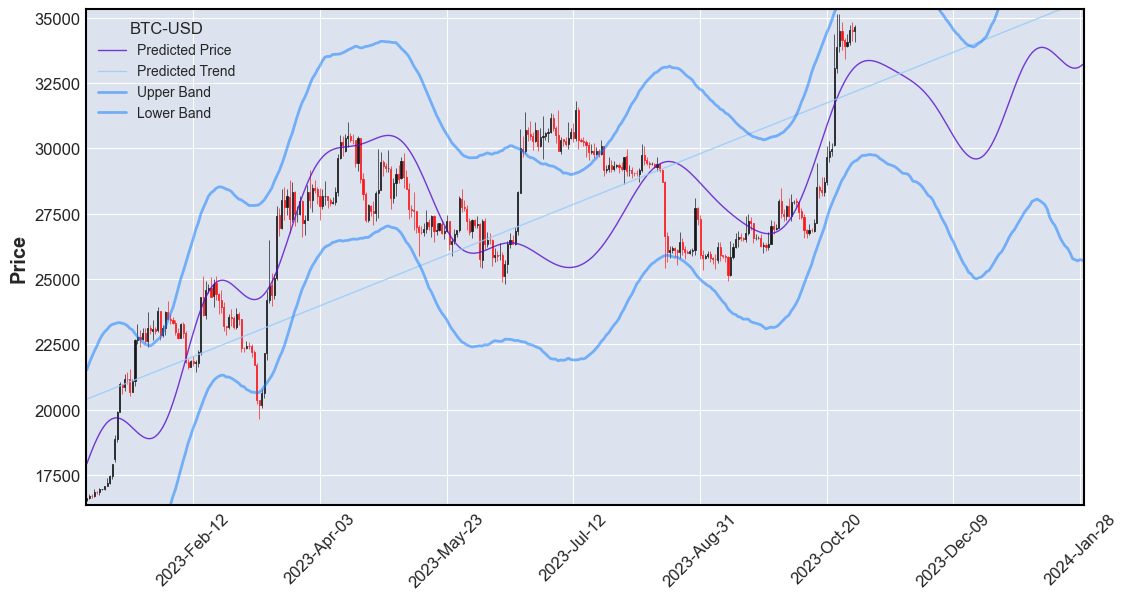

In [58]:
# BTC Longer forecast starting from 2020-01-01
def create_instance_btc():
    global BTC
    global BTC_data
    global BTC_forcasting_prep
    global BTC_forecast
    global BTC_processed_forecast
    global BTC_merged_df

    # create a "SPLG" instance of the UFX class
    BTC = UFX('BTC-USD')
    # splice the data using data starting from 2022-01-01 for forecasting
    BTC_data = BTC.splice_data(BTC.data, '2020-01-01')
    # preppare the data for forecasting
    BTC_forcasting_prep = BTC.forcasting_preparation(BTC_data)
    # forecast the data
    BTC_forecast = BTC.forecast_data(BTC_forcasting_prep)
    # process the forecasted data
    BTC_processed_forecast = BTC.process_forecasted_data(BTC_forecast)
    # merge the dataframes
    BTC_merged_df = BTC.merge_dataframes(BTC_data, BTC_processed_forecast)

# can comment out when playing with the visualizations
create_instance_btc()

# visualizee with plotly
# BTC.plotly_visualize_forecast(BTC_data, BTC_processed_forecast, splice_date='2023-01-01', width=1000, height=600, save_fig=False)
# visualize with mplfinance
# todo Note:: fav styles for MPF are 'blueskies', 'charles', 'classic', 'default', 'kenan', 'mike', 'nightclouds'
BTC.mpf_visualize_forecast(BTC_merged_df, splice_date='2023-01-01', style='kenan')

## BTC SHORT FORECAST

In [59]:
# BTC Shorter forecast starting from 2022-01-01
def create_instance_btc():
    global BTC
    global BTC_data
    global BTC_forcasting_prep
    global BTC_forecast
    global BTC_processed_forecast
    global BTC_merged_df

    # create a "SPLG" instance of the UFX class
    BTC = UFX('BTC-USD')
    # splice the data using data starting from 2022-01-01 for forecasting
    BTC_data = BTC.splice_data(BTC.data, '2022-01-01')
    # preppare the data for forecasting
    BTC_forcasting_prep = BTC.forcasting_preparation(BTC_data)
    # forecast the data
    BTC_forecast = BTC.forecast_data(BTC_forcasting_prep)
    # process the forecasted data
    BTC_processed_forecast = BTC.process_forecasted_data(BTC_forecast)
    # merge the dataframes
    BTC_merged_df = BTC.merge_dataframes(BTC_data, BTC_processed_forecast)

# can comment out when playing with the visualizations
create_instance_btc()

# visualizee with plotly
BTC.plotly_visualize_forecast(BTC_data, BTC_processed_forecast, splice_date='2022-01-01', width=1000, height=600, save_fig=False)
# visualize with mplfinance
# todo Note:: fav styles for MPF are 'blueskies', 'charles', 'classic', 'default', 'kenan', 'mike', 'nightclouds'
# BTC.mpf_visualize_forecast(BTC_merged_df, splice_date='2022-01-01', style='kenan')

[*********************100%***********************]  1 of 1 completed

20:51:13 - cmdstanpy - INFO - Chain [1] start processing
20:51:13 - cmdstanpy - INFO - Chain [1] done processing


# Dividend Forecast

In [14]:
# check dividends
# ticker_list = ['ARLP', 'NS', 'SPH', 'PEAK', 'HTBK', 'ETD']
# ticker_list = ['CFG', 'HAS', 'F', 'ALLY']
ticker_list = ['SLG']

def create_instance_dividends(ticker):
    global DIV
    global _data
    global _forcasting_prep
    global _forecast
    global _processed_forecast
    global _merged_df

    # create a "SPLG" instance of the UFX class
    DIV = UFX(ticker)
    # splice the data using data starting from 2022-01-01 for forecasting
    _data = DIV.splice_data(DIV.data, '2022-01-01')
    # preppare the data for forecasting
    _forcasting_prep = DIV.forcasting_preparation(_data)
    # forecast the data
    _forecast = DIV.forecast_data(_forcasting_prep)
    # process the forecasted data
    _processed_forecast = DIV.process_forecasted_data(_forecast)
    # merge the dataframes
    _merged_df = DIV.merge_dataframes(_data, _processed_forecast)

short_list = []
for symbol in ticker_list:
    # can comment out when playing with the visualizations
    create_instance_dividends(symbol)
    # check if price is less then the lower band
    date = _data.index[-1]
    price = _data.Close[-1]
    # get the data from _merged_df for the date
    lower_band = _merged_df.lower_band.loc[date]
    # check if the price is below the lower band
    if price > lower_band:
        # visualizee with plotly
        DIV.plotly_visualize_forecast(_data, _processed_forecast, splice_date='2022-01-01', width=1000, height=600, save_fig=False)
        # append symbol to the short list
        short_list.append(symbol)
        # visualize with mplfinance
        # todo Note:: fav styles for MPF are 'blueskies', 'charles', 'classic', 'default', 'kenan', 'mike', 'nightclouds'
        # DIV.mpf_visualize_forecast(_merged_df, splice_date='2022-01-01', style='nightclouds')

print('*'*25,"[Buy List]",'*'*25)
print(short_list) 

[*********************100%***********************]  1 of 1 completed

08:26:37 - cmdstanpy - INFO - Chain [1] start processing
08:26:37 - cmdstanpy - INFO - Chain [1] done processing


************************* [Buy List] *************************
['SLG']


## Dividend Buy List 

In [52]:
['NYCB', 'HAFC', 'OCFC']

['PPBI', 'ETRN', 'MITT', 'BMRC']